# IMP npctranport Module Tutorial
##### Written by:
Roi Eliasian roi.eliasian@mail.huji.ac.il 
Barak Raveh barak.raveh@mail.huji.ac.il 
#### Last updated: 
Feb 21st, 2025

This tutorial provides a step-by-step guide to executing an NPC transport simulation using the `npctransport` module, and analyzing the results. The model is a simplified version, see User's manual to see how to run simulations for the full NPC.

Before proceeding, ensure that you are running this notebook in a Python environment with the `IMP`, `NumPy` and `matplotlib` libraries installed.
See https://integrativemodeling.org/nightly/doc/manual/installation.html for installation instructions, including on Google Colab.


## 1. Configuration Files

Before running the simulation, a configuration file must be generated. This file defines the components of the simulation (e.g., FG Nups, NTRs) and their interactions.

The following code generates a sample configuration file describing a simplified pore structure. This pore consists solely of NSP1 Nups and follows a basic toroidal scaffold shape. Additionally, a number of NTRs are included.

For details on the configration parameters, please refer to the simulation manual.

In [26]:
# Make temporary output folder (feel free to change OUTPUT_FOLDER to your liking)
import os
OUTPUT_FOLDER = "tmp_output/"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
# export OUTPUT_FOLDER to environment variable so IMP can find it
os.environ["OUTPUT_FOLDER"] = OUTPUT_FOLDER

In [ ]:
#!/usr/bin/python
from IMP.npctransport import *
import itertools
import numpy as np

SIMULATION_TIME_NS = 200 # total simulation time will greatly affect runtime (bestr not below 10 for this test)
SIMULATION_OUTPUT_STATISTICS_INTERVAL_NS = 1 # interval at which output statistics are recorded
BOUNDING_BOX_SIDE_A = 1000 # side of the cubic bounding box
NUCLEAR_ENVELOPE_THICKNESS_A = 150
N_NTRS = 400

outfile = OUTPUT_FOLDER+"config.pb"
# See User's manual for interpretation of parameters
config = Configuration()
IMP.npctransport.set_default_configuration(config)
config.statistics_fraction.lower = 1.0
config.interaction_k.lower = 1e-09
config.interaction_range.lower = 10
config.backbone_k.lower = 0.0075
config.time_step_factor.lower = 2.0
config.slack.lower = 10
config.number_of_trials = 1
config.statistics_interval_ns = 0.1
config.dump_interval_ns = 1
config.output_statistics_interval_ns = SIMULATION_OUTPUT_STATISTICS_INTERVAL_NS
config.simulation_time_ns = SIMULATION_TIME_NS
config.box_is_on.lower = 1
config.box_side.lower = BOUNDING_BOX_SIDE_A
config.slab_is_on.lower = 2
config.slab_thickness.lower = NUCLEAR_ENVELOPE_THICKNESS_A
config.tunnel_radius.lower = 185
config.is_xyz_hist_stats = 1
config.backbone_tau_ns.lower = 50.0
config.is_backbone_harmonic = 1
config.xyz_stats_crop_factor = 1
config.xyz_stats_voxel_size_a = 10
config.xyz_stats_max_box_size_a = 700
config.nonspecific_k.lower = 0.01
config.excluded_volume_k.lower = 10.0
config.angular_D_factor.lower=0.3
config.is_multiple_hdf5s = False
config.full_output_statistics_interval_factor = 1


anchor_coordinates = [[185.0, 0.0, -75.0], [130.8147545195113, 130.8147545195113, -75.0], [1.1327982892113017e-14, 185.0, -75.0], [-130.81475451951127, 130.8147545195113, -75.0], [-185.0, 2.2655965784226034e-14, -75.0], [-130.81475451951133, -130.81475451951127, -75.0], [-3.398394867633905e-14, -185.0, -75.0], [130.81475451951127, -130.81475451951133, -75.0], [120.0480947161671, 0.0, -37.5], [84.88682184232671, 84.88682184232671, -37.5], [7.350825746894615e-15, 120.0480947161671, -37.5], [-84.8868218423267, 84.88682184232671, -37.5], [-120.0480947161671, 1.470165149378923e-14, -37.5], [-84.88682184232673, -84.8868218423267, -37.5], [-2.2052477240683848e-14, -120.0480947161671, -37.5], [84.88682184232668, -84.88682184232673, -37.5], [120.0480947161671, 0.0, 37.499999999999986], [84.88682184232671, 84.88682184232671, 37.499999999999986], [7.350825746894615e-15, 120.0480947161671, 37.499999999999986], [-84.8868218423267, 84.88682184232671, 37.499999999999986], [-120.0480947161671, 1.470165149378923e-14, 37.499999999999986], [-84.88682184232673, -84.8868218423267, 37.499999999999986], [-2.2052477240683848e-14, -120.0480947161671, 37.499999999999986], [84.88682184232668, -84.88682184232673, 37.499999999999986], [185.0, 0.0, 75.0], [130.8147545195113, 130.8147545195113, 75.0], [1.1327982892113017e-14, 185.0, 75.0], [-130.81475451951127, 130.8147545195113, 75.0], [-185.0, 2.2655965784226034e-14, 75.0], [-130.81475451951133, -130.81475451951127, 75.0], [-3.398394867633905e-14, -185.0, 75.0], [130.81475451951127, -130.81475451951133, 75.0]]
suffix_list = ["_C"] * 12 + ["_N"] * 4
#lowered the amount of beads proportinaly and same with the type: 23,9 -> 12,4

############
# Add FGs: #
############

fgs = []
for frame_i, coordinates in enumerate(anchor_coordinates):
    cur_fg = IMP.npctransport.add_fg_type(config,
                                          type_name=f"fg{frame_i}",
                                          number_of_beads=16,
                                          number=1,
                                          radius=8.0,
                                          interactions=1,
                                          rest_length_factor=1.9,
                                          d_factor=1.0,
                                          interaction_k_factor=1.0,
                                          interaction_range_factor=1.0)
    pos = cur_fg.anchor_coordinates.add()
    pos.x = coordinates[0]
    pos.y = coordinates[1]
    pos.z = coordinates[2]
    fgs.append(cur_fg)
    cur_fg.type_suffix_list.extend(suffix_list)

#################################
# add internal fg interactions: #
#################################
self_k_N = 1.47
self_k_C = 1.32
self_range = 6.00
self_nonspec_k_N = 0.01
self_nonspec_k_C = 0.08
for frame_i in itertools.combinations_with_replacement(range(len(fgs)), 2):
    for suffix0 in ["_N", "_C"]:
        for suffix1 in ["_N", "_C"]:
            interactionFG_FG = IMP.npctransport.add_interaction(config,
                                                        name0=f"fg{frame_i[0]}{suffix0}",
                                                        name1=f"fg{frame_i[1]}{suffix1}",
                                                        interaction_k=0.5*(self_k_N if suffix0=="_N" else self_k_C) + 0.5*(self_k_N if suffix1=="_N" else self_k_C),
                                                        interaction_range=self_range)
            interactionFG_FG.nonspecific_k.lower = np.sqrt((self_nonspec_k_N if suffix0=="_N" else self_nonspec_k_C) * (self_nonspec_k_N if suffix1=="_N" else self_nonspec_k_C))

#############
# Add NTRs: #
#############

ntr_vals = [(30,5)] # Radius 30, 5 Interaction sites distributed uniformally
ntrs = []
for vals in ntr_vals:
    cur_ntr  = IMP.npctransport.add_float_type(config,
                                number=N_NTRS,
                                radius=vals[0],
                                type_name=f"NTR{vals[0]}",
                                interactions=vals[1],
                                d_factor=1.0,
                                interaction_k_factor=1.0,
                                interaction_range_factor=1.0)
    ntrs.append(cur_ntr)

############################
# Add NTR-FG interactions: #
############################
for frame_i in range(len(fgs)):
    for vals in ntr_vals:
        for suffix in ["_N", "_C"]:
            IMP.npctransport.add_interaction(config,
                                     name0=f"fg{frame_i}{suffix}",
                                     name1=f"NTR{vals[0]}",
                                     interaction_k=2.64,
                                     interaction_range=5.5,
                                     range_sigma0_deg=45.0,
                                     range_sigma1_deg=45.0)

# dump to file
f = open(outfile, "wb")
f.write(config.SerializeToString())

127416

## 2. Running the Simulation
With the configuration file generated, we are now ready to run the simulation. The configuration file is provided to the `fg_simulation` executable, found in the IMP installation, via the `--configuration` flag.

For details on additional flags that can be passed to the simulation executable, please refer to the simulation manual.

In [28]:
%%bash
FG_SIMULATION_EXE=fg_simulation # Insert path to the fg_simulation binary 
                                # In CONDA, simply install imp and it will be in the path (it is installed in $CONDA_PREFIX/bin/)
                                # In source installation, it will be in the <build-folder>/bin/fg_simulation
echo Output folder: $OUTPUT_FOLDER
CONFIG_PATH=${OUTPUT_FOLDER}/config.pb # From previous section

${FG_SIMULATION_EXE} --configuration ${CONFIG_PATH} --output ${OUTPUT_FOLDER}/output.pb --conformations ${OUTPUT_FOLDER}/movie.rmf --final_conformations ${OUTPUT_FOLDER}/final.rmf --short_init_factor 0.5 --short_sim_factor 1.00



Output folder: tmp_output/
Random seed is 3955386438
begin main:
  begin assign_ranges:
    WARNING  No message with value ranges detected for file 'tmp_output//config.pb' - this is probably fine
  end assign_ranges
  WARNING  5 sites added 
"NTR30"
["NTR30", "NTR30", "NTR30", "NTR30", "NTR30", "NTR30", "NTR30", "NTR30", "NTR30", "NTR30", "NTR30", ,...]Simulation trial 0 out of 1
Doing initial coordinates optimization...
  begin iteration:
    begin initialize_positions:
      begin optimize_balls:
        optimize_balls for n_particles=16 15 optimizables
        Optimizing with radii at 0.001 of full for optimizables and length factor 502.812
         energy before = 1.09161e+06
        Energy after bd is 74107.1 at ramp level 0.001, 0
        Energy after bd is 57492.3 at ramp level 0.001, 1
        Energy after bd is 56685.4 at ramp level 0.001, 2
        KeyData::add_key exclusive consecutive container
        Energy after bd is 56582.7 at ramp level 0.001, 3
        Energy after b

## 3. Processing simulation output

The command above will execute the simulation, running for 1000 ns as specified in the previously generated configuration file. Upon completion, the simulation will produce three output files:
- `output.pb` – Contains various statistical data about the simulation. This file can be processed using the IMP library in Python (see Section 3.1).
- `output.movie.rmf` – Stores molecular trajectory data for the entire simulation, following the RMF format. The framerate is determined by the `output_statistics_interval_ns` parameter in the configuration file.
- `output.final.rmf` – Contains only the final conformations from the simulation.

The RMF files adhere to the format described [here](https://integrativemodeling.org/rmf/format.html). These trajectory files can be visualized using [UCSF Chimera](https://www.cgl.ucsf.edu/chimera/) or manually processed with the IMP library (see Section 3.2).


### 3.1 Processing output.pb
The following plots a measure of the free energy of the simulation over time. (Just one of the many statistics that the simulation computes and saves in the `pb` format. A full list can be found here [here](https://github.com/salilab/npctransport/blob/b411ecb0a260d99a8e15e7fbb080cadc2efd362a/data/npctransport.proto)).

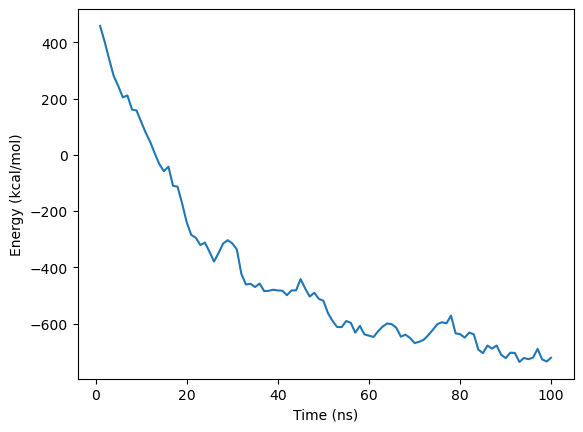

In [29]:
import IMP.npctransport
import matplotlib.pyplot as plt

def load_time_energy(pb_path):
    with open(pb_path, "rb") as f:
        output = IMP.npctransport.Output()
        fstring = f.read()
        output.ParseFromString(fstring)
        time_ns = []
        energy = []
        for i in range(len(output.statistics.global_order_params)):
            time_ns.append(output.statistics.global_order_params[i].time_ns)
            energy.append(output.statistics.global_order_params[i].energy)
    return time_ns, energy

def plot_energy(time, energy):
    plt.plot(time, energy)
    plt.xlabel("Time (ns)")
    plt.ylabel("Energy (kcal/mol)")
    plt.show()
    
time, energy = load_time_energy(f"{OUTPUT_FOLDER}/output.pb")
plot_energy(time, energy)

### 3.2 Visualizing RMF trajectories
You may visualize RMF trajectories by loading them in Chimera or ChimeraX (may require a simple plug-in, please search online for current status).

For example, you can load movie.rmf in Chimera to see the trajectory over time, or final.rmf for just the final coordinates.

### 3.3 Processing RMF trajectories
The following code reads the trajectories of the NTRs in `output.final.rmf` and converts them to a simple numpy array of the shape \[n_NTRs, 3, n_frames\] 

In [39]:
import RMF
import numpy as np

def _rmf_has_depth_with_site(root, i):
    """ returns true if node subtree thru first child is at least i
        levels, including the root node itself, and the lead is a site """
#  print root, i, len(root.get_children())
    if (i==1) and root.get_name()=="site":
        return True
    c = root.get_children()
    if len(c) == 0:
        return False
    return _rmf_has_depth_with_site(c[0], i-1)

def _rmf_add_nodes(node, tf, type_prefixes, depth=0):
    '''
    node - rmf node to scan
    tf - typed factory
    type_prefixes - list of full type prefixes (e.g. "Nup1" for "Nup1N")

    adds only nodes whose type name begins with any of the specified type prefixes
    '''
    children = node.get_children()
    ret = []
    if len(children)==0:
        return ret
    if _rmf_has_depth_with_site(node, 3) and tf.get_is(children[0]):
        child_type = tf.get(children[0]).get_type_name()
        if any([child_type.startswith(tp) for tp in type_prefixes]):
            ret.append(children)
    for c in children:
        ret += _rmf_add_nodes(c, tf,  type_prefixes, depth+1)
    return ret

def _rmf_add_nodes_exact(node, tf, types, depth=0):
    '''
    node - rmf node to scan
    tf - typed factory
    types - list of full types (e.g. "Nup1N")

    adds only nodes whose type name begins with any of the specified type prefixes
    '''
    children = node.get_children()
    ret = []
    if len(children)==0:
        return ret
    if _rmf_has_depth_with_site(node, 3) and tf.get_is(children[0]):
        child_type = tf.get(children[0]).get_type_name()
        if any([child_type == tp for tp in types]):
            ret.append(children)
    for c in children:
        ret += _rmf_add_nodes_exact(c, tf,  types, depth+1)
    return ret

def load_NTR_data_from_RMF(rmf_path, n_NTRs, max_frames_per_file):
    ''' 
    Load NTR trajectories from an RMF file for the first NTR type 
    @param rmf_path:      Path to the RMF file
    @param n_NTRs:        Number of NTRs in the simulation
    @param max_frames_per_file: Maximal number of frames to read from the RMF file 
                            (from the end of the file)
    @return:              Numpy array of shape (n_NTRs, 3, frames_per_file)
                          containing the trajectories of the NTRs in angstrom units
                          that is trajectories[NTR_index, x/y/z, frame_index]
    '''
    print("Max frames per file:", max_frames_per_file)
    in_fh = RMF.open_rmf_file_read_only(rmf_path)
    rff = RMF.ReferenceFrameFactory(in_fh)
    tf = RMF.TypedFactory(in_fh)
    radii = [30]
    NTR_types = [f"NTR{radius}" for radius in radii] # name defined in config.pb
    # load data
    type2chains={}
    for NTR_type in NTR_types:
        type2chains[NTR_type] = _rmf_add_nodes(in_fh.get_root_node(), tf, [NTR_type])
    NTR_type = NTR_types[0] # for this test we use only one type
    frames = list(in_fh.get_frames())
    frame_i = 0
    if len(frames) > max_frames_per_file:
        frame_i = len(frames) - max_frames_per_file
        frames = frames[-max_frames_per_file:]
    trajectories = np.zeros(shape=[n_NTRs, 3, len(frames)], dtype=np.float32)
    for fi, f in enumerate(frames):
        in_fh.set_current_frame(f)
        # read data
        for NTR_i in range(n_NTRs):
            coord = rff.get(type2chains[NTR_type][0][NTR_i]).get_translation() 
            trajectories[NTR_i, 0, fi] = coord[0] 
            trajectories[NTR_i, 1, fi] = coord[1] 
            trajectories[NTR_i, 2, fi] = coord[2] 
        frame_i += 1     
    print("Read", len(frames), "frames from", rmf_path)
    return trajectories

trajectories = load_NTR_data_from_RMF(f"{OUTPUT_FOLDER}/movie.rmf", N_NTRS, max_frames_per_file=10)

Max frames per file: 10
Read 10 frames from tmp_output//movie.rmf


Some demo analysis of the trajectories:

In [40]:
import scipy.stats

Z = trajectories[:, 2, :].flatten() # all NTRs and all frames
# Compute mean Z over all NTRs and all frames
mean_z = np.mean(Z)
stddev_z = scipy.stats.tstd(Z) if len(trajectories) > 1 else 0.0
stderr_z = scipy.stats.sem(Z) if len(trajectories) > 1 else 0.0
print(f"Mean Z of NTRs: {mean_z} A")
print(f"Std-dev Z of NTRs: {stddev_z} A")
print(f"Std-error Z of NTRs: {stderr_z} A")
# Count how many NTRs are within the pore region 
ntr_in_pore = np.sum(np.abs(Z) < NUCLEAR_ENVELOPE_THICKNESS_A/2) / trajectories.shape[2] # average per frame
fraction_in_pore = ntr_in_pore / (N_NTRS * 1)
print(f"Percentage of NTRs in pore (|Z|<NE/2): {100*fraction_in_pore:.2f}%; {ntr_in_pore} out of {N_NTRS} NTRs")
R = np.sqrt(trajectories[:, 0, :]**2 + trajectories[:, 1, :]**2).flatten()
R_in_pore = R[np.abs(Z) < NUCLEAR_ENVELOPE_THICKNESS_A/2]
if len(R_in_pore) == 0:
    print("No NTRs found in pore region for R statistics")
else:
    mean_R_in_pore = np.mean(R_in_pore) 
    stddev_R_in_pore = scipy.stats.tstd(R_in_pore) if len(R_in_pore) > 1 else 0.0
    stderr_R_in_pore = scipy.stats.sem(R_in_pore) if len(R_in_pore) > 1 else 0.0
    print(f"Mean R of NTRs in pore (|Z|<NE/2): {mean_R_in_pore} A")   
    print(f"Std-dev R of NTRs: {stddev_R_in_pore} A")
    print(f"Std-error R of NTRs: {stderr_R_in_pore} A")


Mean Z of NTRs: 16.12989044189453 A
Std-dev Z of NTRs: 320.197265625 A
Std-error Z of NTRs: 5.062763214111328 A
Percentage of NTRs in pore (|Z|<NE/2): 0.00%; 0.0 out of 400 NTRs
No NTRs found in pore region for R statistics


Visualize histogram over Z axis and over R axis in pore

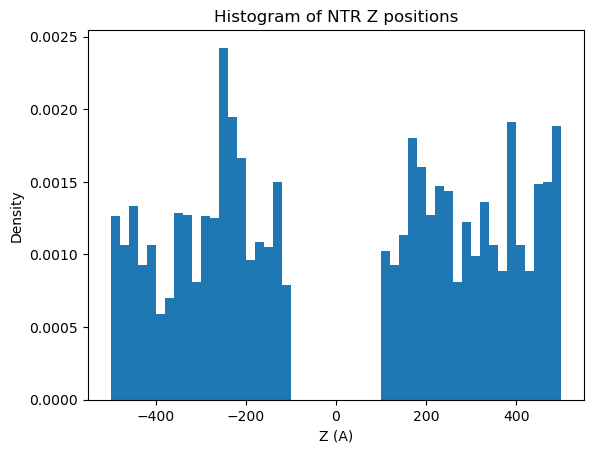

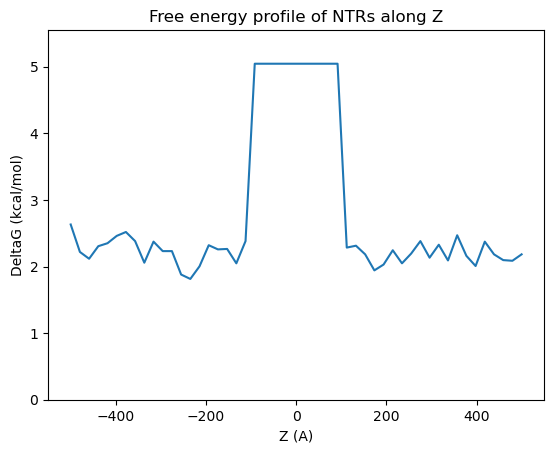

No NTRs found in pore region for R statistics


In [47]:
# Plot Z histogram
plt.hist(Z, bins=50, density=True)
plt.xlabel("Z (A)")
plt.ylabel("Density")
plt.title("Histogram of NTR Z positions")
plt.show()

# Plot deltaG(Z) with 0.1 pseudocounts
z_range_limit = max(abs(np.min(Z)), abs(np.max(Z)))
# round up to nearest 10
z_range_limit = int(np.ceil(z_range_limit / 10.0)) * 10
z_range = (-z_range_limit, z_range_limit)
hist, bin_edges = np.histogram(Z, bins=50, range=z_range, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
pseudocount = 0.00001
prob = hist + pseudocount
prob /= np.sum(prob) # renormalize
kT = 0.593 # kcal/mol at 300K
deltaG = -kT * np.log(prob)
plt.plot(bin_centers, deltaG)
plt.xlabel("Z (A)")
plt.ylabel("DeltaG (kcal/mol)")
plt.title("Free energy profile of NTRs along Z")
plt.ylim(0, np.max(deltaG[np.isfinite(deltaG)])*1.1)
plt.show()

# Plot R histogram in pore
if len(R_in_pore) == 0:
    print("No NTRs found in pore region for R statistics")
else:
    plt.hist(R_in_pore, bins=50, density=True)
    plt.xlabel("R (A)")
    plt.ylabel("Density")
    plt.title("Histogram of NTR R positions in pore (|Z|<NE/2)")
    plt.show()